In [110]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from utils.ephys_functions import cross_corr_train, auto_corr_train, load_drift, load_auto_corr, load_cross_corr

from cross_auto_corr import cross_auto_corr
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.gridspec as gs
import numpy as np
from utils.combine_tools import apply_qc, spatial_dependence_summary
from utils.ccf_utils import pir_to_lps, project_to_plane
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import rankdata
from trimesh import load_mesh
%matplotlib inline


# Load data

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 18300 -> 8322 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8322 -> 5849 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5849 -> 5826 units passed
Applying conditional bounds for y_loc
 - y_loc: 5826 -> 4439 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 414
Number of non-opto units after filtering: 4439


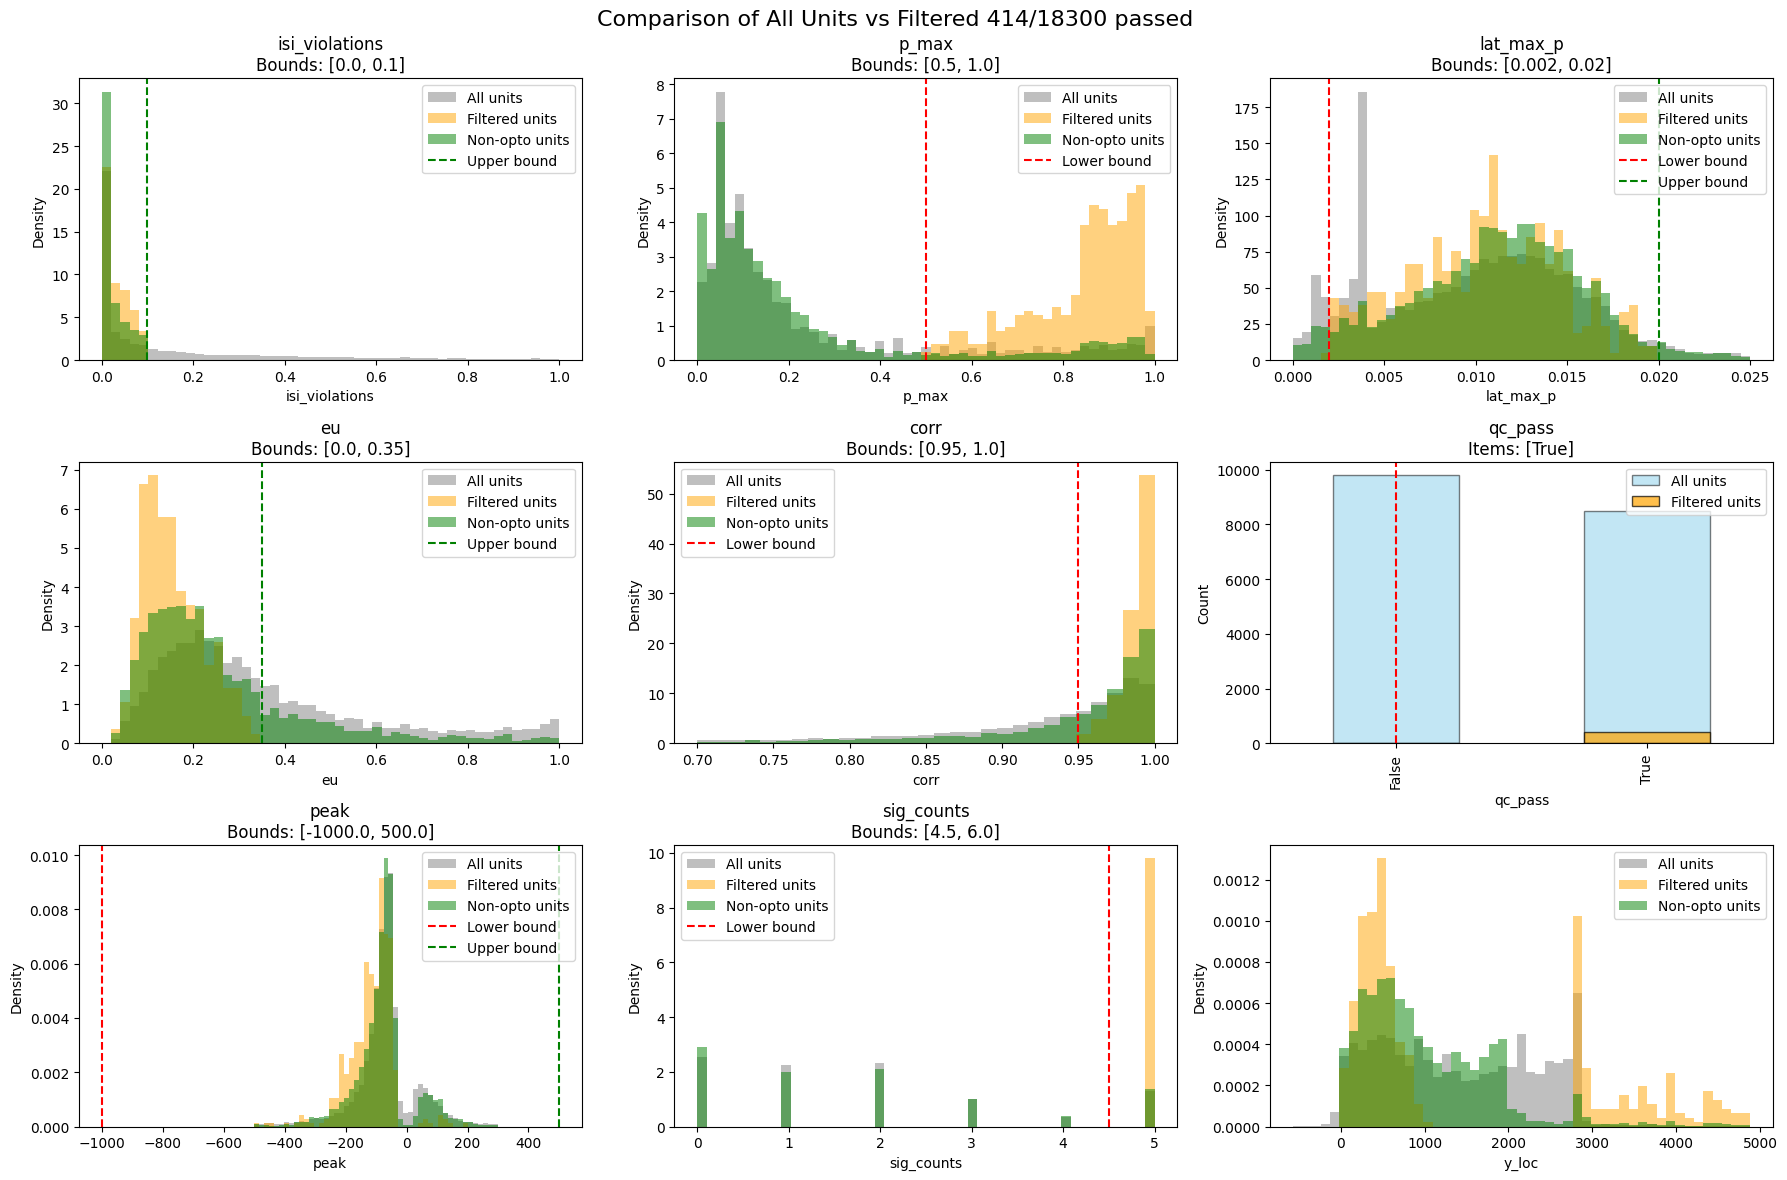

In [42]:
criteria_name = 'basic_ephys'
target_folder = f'/root/capsule/scratch/manuscript/F_cross_corr'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [23]:
# loop trough all unit and load auto corr
from joblib import Parallel, delayed

def _fetch_one(session, unit_id, data_type="curated"):
    auto_corr = load_auto_corr(session, data_type)
    auto_unit = auto_corr.load_unit(unit_id)

    if auto_unit is None:
        return None, None, np.nan

    long_ = auto_unit.get("auto_corr_long_nogo", None)
    short_ = auto_unit.get("auto_corr_short_nogo", None)

    start = auto_unit.get("start", np.nan)
    end = auto_unit.get("end", np.nan)
    length = (end - start) if (np.isfinite(start) and np.isfinite(end)) else np.nan

    return long_, short_, length

# prepare lightweight inputs
sessions = combined_tagged_units_filtered["session"].to_numpy()
unit_ids = combined_tagged_units_filtered["unit"].to_numpy()

# run in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(_fetch_one)(s, u, "curated") for s, u in zip(sessions, unit_ids)
)

auto_corr_list_long, auto_corr_list_short, lengths = map(list, zip(*results))

# assign back
combined_tagged_units_filtered["auto_corr_long_nogo"] = auto_corr_list_long
combined_tagged_units_filtered["auto_corr_short_nogo"] = auto_corr_list_short
combined_tagged_units_filtered["length"] = lengths


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [28]:
filter = (combined_tagged_units_filtered['sd'] < 0.3) & (combined_tagged_units_filtered['length'] > 1000)

In [30]:
combined_tagged_units_filtered = combined_tagged_units_filtered[filter].reset_index(drop=True)

In [31]:
# loop through sessions and find a table of session - unit_1 - unit_2 dataframe to load 
session_unit_pairs = []
for session in combined_tagged_units_filtered['session'].unique():
    session_df = combined_tagged_units_filtered[combined_tagged_units_filtered['session'] == session]
    unit_ids = session_df['unit'].to_list()
    for i in range(len(unit_ids)):
        for j in range(i+1, len(unit_ids)):
            session_unit_pairs.append((session, (unit_ids[i], unit_ids[j])))
session_unit_pairs_df = pd.DataFrame(session_unit_pairs, columns=['session', 'unit_pair'])

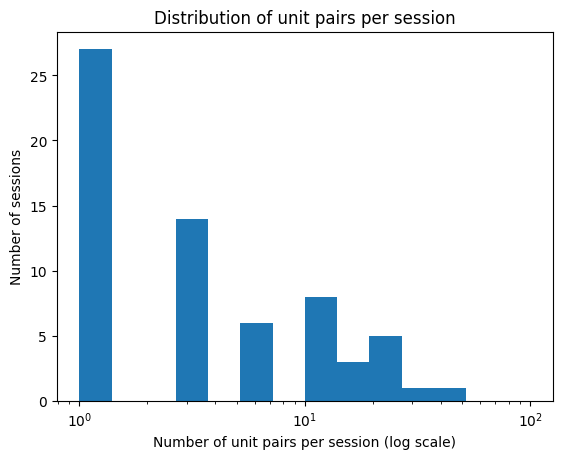

In [54]:
# set up bin edges proper for log scale
bin_edges = np.logspace(0, 2, num=15)
# plot histogram of number of unit pairs per session
plt.hist(session_unit_pairs_df.groupby("session")["unit_pair"].count(), bins = bin_edges)
# change x axis to log scale
plt.xscale("log")
plt.xlabel("Number of unit pairs per session (log scale)")
plt.ylabel("Number of sessions")
plt.title("Distribution of unit pairs per session")
plt.savefig(os.path.join(target_folder, 'unit_pairs_per_session_histogram.pdf'))

In [38]:
from joblib import Parallel, delayed
import numpy as np

def _fetch_one(session, unit_pair, data_type):
    cross_corr = load_cross_corr(session, data_type)
    if cross_corr is None:
        return None, session

    pair_cross = cross_corr.load_units(unit_pair[0], unit_pair[1])
    if pair_cross is None:
        return None, session

    pair_cross = pair_cross.copy()
    pair_cross["length"] = pair_cross["end"] - pair_cross["start"]
    return pair_cross, session


results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(_fetch_one)(row["session"], row["unit_pair"], data_type)
    for _, row in session_unit_pairs_df.iterrows()
)

cross_corr_list, session_list = map(list, zip(*results))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [39]:
cross_corr_df = pd.DataFrame(cross_corr_list)
cross_corr_df["session"] = session_list

# find location of each neuron, unit 1 and unit 2, load both ccf locations and y_loc (estimated location along the probe)
cross_corr_df['unit'] = cross_corr_df['unit_1']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 1
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_1', 'x_ccf': 'x_ccf_1', 'y_ccf': 'y_ccf_1', 'z_ccf': 'z_ccf_1'})
cross_corr_df['unit'] = cross_corr_df['unit_2']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 2
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_2', 'x_ccf': 'x_ccf_2', 'y_ccf': 'y_ccf_2', 'z_ccf': 'z_ccf_2'})

In [40]:
print(f'Total unit pairs with cross-corr data: {len(cross_corr_df)}')

Total unit pairs with cross-corr data: 416


# Summarize autocorr and crosscorr features

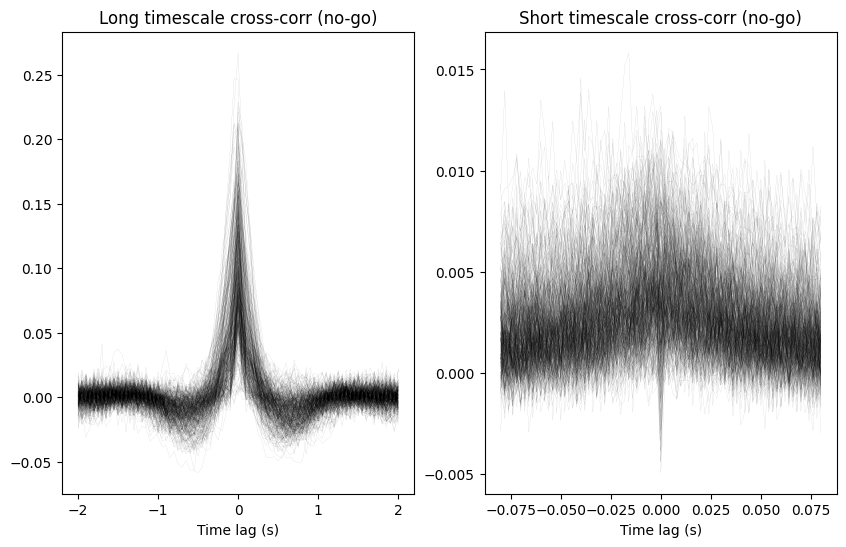

In [41]:
# plot all traces
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for idx, row in cross_corr_df.iterrows():
    pair_cross = row
    if pair_cross is not None:
        times = pair_cross['long_lags']
        corr_values = pair_cross['cross_corr_long_nogo']
        ax[0].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
        times = pair_cross['short_lags']
        corr_values = pair_cross['cross_corr_short_nogo']
        ax[1].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
ax[0].set_xlabel('Time lag (s)')
ax[0].set_title('Long timescale cross-corr (no-go)')
ax[1].set_xlabel('Time lag (s)')
ax[1].set_title('Short timescale cross-corr (no-go)')
fig.savefig(os.path.join(target_folder, 'all_unit_pairs_cross_corr.pdf'), dpi=300)

In [61]:
times_long = pair_cross['long_lags']
times_short = pair_cross['short_lags']

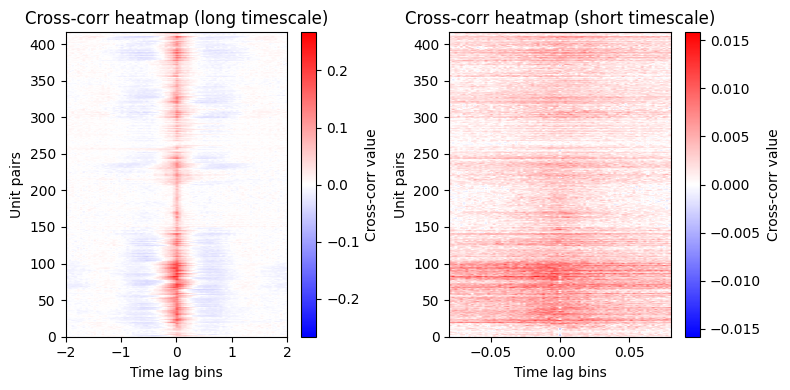

In [71]:
# use image to plot average them as heatmap
# prepare data matrix
data_matrix_long = []
data_matrix_short = []
valid_indices = []
# make a colormap, from blue to white to red, with zero at white
custom_cmap = LinearSegmentedColormap.from_list('outcome', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')])
for idx, row in cross_corr_df.iterrows():
    pair_cross = row
    if pair_cross is not None:
        corr_values_long = pair_cross['cross_corr_long_nogo']
        corr_values_short = pair_cross['cross_corr_short_nogo']
        data_matrix_long.append(corr_values_long)
        data_matrix_short.append(corr_values_short)
        valid_indices.append(idx)
data_matrix_long = np.array(data_matrix_long)

# plot heatmap
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
im = axes[0].imshow(data_matrix_long, aspect='auto', 
                    cmap=custom_cmap, 
                    extent=[times_long[0], times_long[-1], 0, data_matrix_long.shape[0]], 
                    vmin=-np.max(np.abs(data_matrix_long)), vmax=np.max(np.abs(data_matrix_long)))
axes[0].set_xlabel('Time lag bins')
axes[0].set_ylabel('Unit pairs')
axes[0].set_title(f'Cross-corr heatmap (long timescale)')
fig.colorbar(im, ax=axes[0], label='Cross-corr value')

data_matrix_short = np.array(data_matrix_short)
im = axes[1].imshow(data_matrix_short, aspect='auto', 
                    cmap=custom_cmap,  
                    extent=[times_short[0], times_short[-1], 0, data_matrix_short.shape[0]],
                    vmin=-np.max(np.abs(data_matrix_short)), vmax=np.max(np.abs(data_matrix_short)))
axes[1].set_xlabel('Time lag bins')
axes[1].set_ylabel('Unit pairs')
axes[1].set_title(f'Cross-corr heatmap (short timescale)')
fig.colorbar(im, ax=axes[1], label='Cross-corr value')
plt.tight_layout()
fig.savefig(os.path.join(target_folder, 'cross_corr_heatmap_all_unit_pairs.pdf'), dpi=300)


In [73]:
all_long_corr = np.array(cross_corr_df['cross_corr_long_nogo'].to_list())
all_short_corr = np.array(cross_corr_df['cross_corr_short_nogo'].to_list())
center_long = all_long_corr[:, all_long_corr.shape[1] // 2]
center_short = all_short_corr[:, all_short_corr.shape[1] // 2]

In [74]:
# zscore
from scipy.stats import zscore
balanced_long_corr = all_long_corr - np.mean(all_long_corr, axis=0, keepdims=True)
balanced_long_corr = zscore(balanced_long_corr, axis=0)
# balanced_long_corr = zscore(balanced_long_corr, axis=0)
balanced_long_corr = np.concat([balanced_long_corr, np.flip(balanced_long_corr, 1)], axis=0)
all_long_corr_for_plot = np.concat([all_long_corr, np.flip(all_long_corr, 1)], axis=0)

In [75]:
# zscore
from scipy.stats import zscore
balanced_short_corr = all_short_corr - np.mean(all_short_corr, axis=0, keepdims=True)
balanced_short_corr = zscore(balanced_short_corr, axis=0)
# balanced_short_corr = zscore(balanced_short_corr, axis=0)
balanced_short_corr = np.concat([balanced_short_corr, np.flip(balanced_short_corr, 1)], axis=0)
all_short_corr_for_plot = np.concat([all_short_corr, np.flip(all_short_corr, 1)], axis=0)

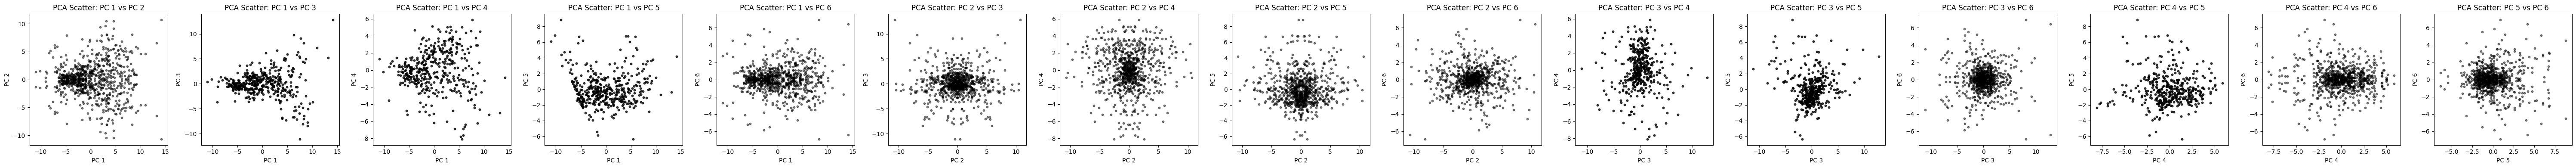

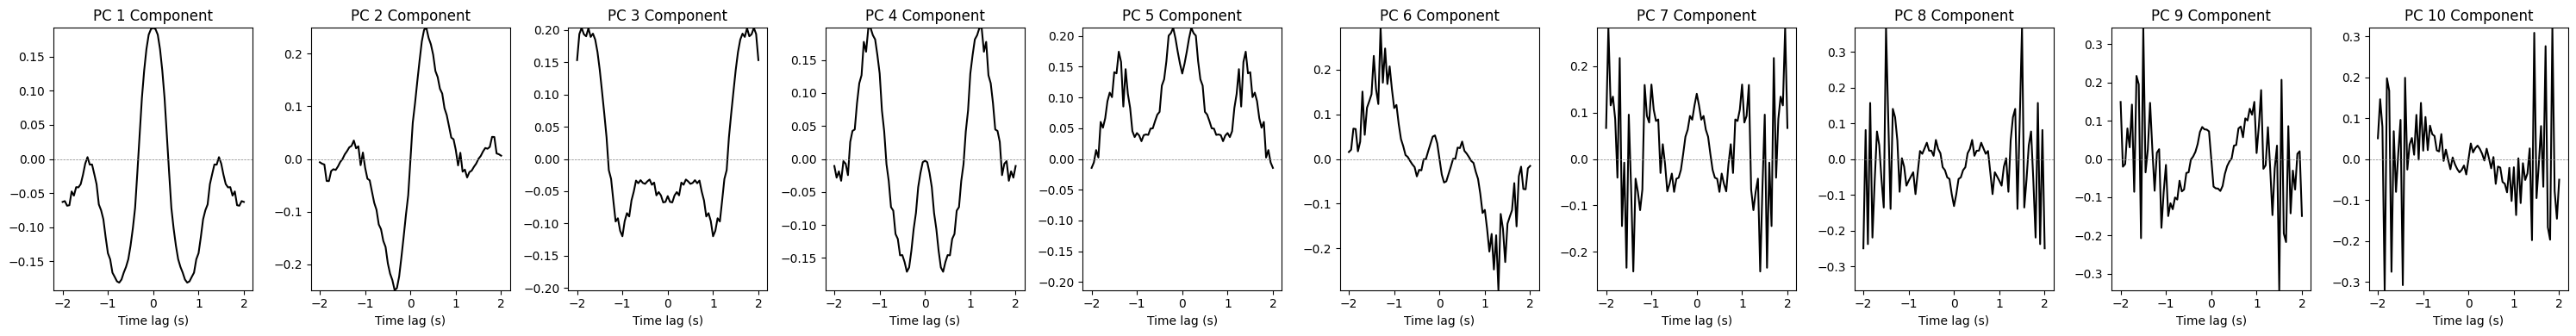

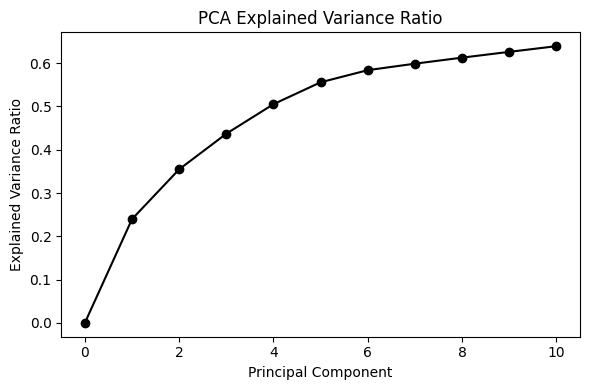

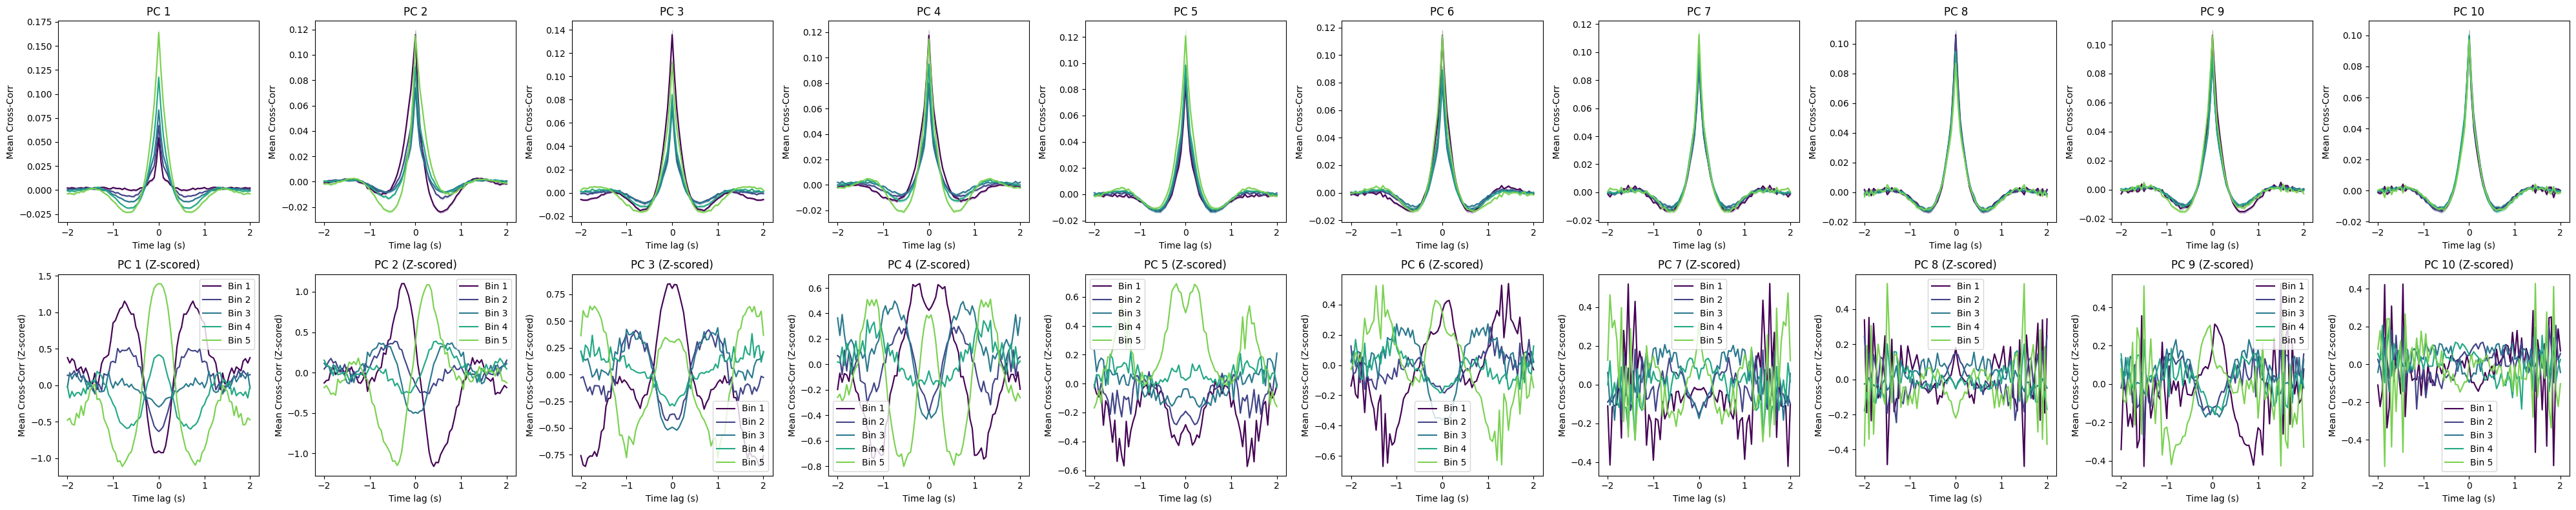

In [76]:
# pca on long timescale cross-corr long term
from sklearn.decomposition import PCA
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(balanced_long_corr)
long_corr_pca = pca.transform(balanced_long_corr)
import itertools
import matplotlib.pyplot as plt

def plot_pca_pairs(pca_data, max_components=None, figsize=(12, 4)):
    """
    pca_data: array (n_samples × n_components)
    max_components: number of components to visualize (default = all)
    """

    # Determine how many components to use
    n_components = pca_data.shape[1]
    if max_components is not None:
        n_components = min(max_components, n_components)

    component_indices = range(n_components)

    # Generate all unique pairs: (0,1), (0,2), (1,2), ...
    pairs = list(itertools.combinations(component_indices, 2))

    # Determine layout
    n_plots = len(pairs)
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), squeeze=False)
    axes = axes.ravel()

    # Plot each pair
    for ax, (i, j) in zip(axes, pairs):
        ax.scatter(pca_data[:, i], pca_data[:, j], alpha=0.5, color='k', s=10)
        ax.set_xlabel(f"PC {i+1}")
        ax.set_ylabel(f"PC {j+1}")
        ax.set_title(f"PCA Scatter: PC {i+1} vs PC {j+1}")

    plt.tight_layout()
    return fig, axes

fig, axes = plot_pca_pairs(long_corr_pca, max_components=6)

# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['long_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'cross_corr_pca_components.pdf'), dpi=300)  

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'cross_corr_pca_explained_variance.pdf'), dpi=300)


# plot mean of cross correltions binned by score of each pc
num_bins = 5
fig, axes = plt.subplots(2, num_components, figsize=(4*num_components, 8))
for pc_idx in range(num_components):
    pc_scores = long_corr_pca[:, pc_idx]
    bin_edges = np.percentile(pc_scores, np.linspace(0, 100, num_bins + 1))
    binned_means = []
    binned_means_ori = []
    binned_sems = []
    binned_sems_ori = []
    for i in range(num_bins):
        bin_mask = (pc_scores >= bin_edges[i]) & (pc_scores < bin_edges[i + 1])
        bin_data = all_long_corr_for_plot[bin_mask]
        bin_data_ori = balanced_long_corr[bin_mask]
        mean_corr = np.mean(bin_data, axis=0)
        mean_corr_ori = np.mean(bin_data_ori, axis=0)
        sem_corr = np.std(bin_data, axis=0) / np.sqrt(bin_data.shape[0])
        sem_corr_ori = np.std(bin_data_ori, axis=0) / np.sqrt(bin_data_ori.shape[0])
        binned_means.append(mean_corr)
        binned_means_ori.append(mean_corr_ori)
        binned_sems.append(sem_corr)
        binned_sems_ori.append(sem_corr)
    
    # Plotting
    ax = axes[0, pc_idx]
    lags = cross_corr_df.iloc[0]['long_lags']
    for i in range(num_bins):
        ax.plot(lags, binned_means[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means[i] - binned_sems[i], 
                        binned_means[i] + binned_sems[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1}')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr')
    
    ax = axes[1, pc_idx]
    for i in range(num_bins):
        ax.plot(lags, binned_means_ori[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means_ori[i] - binned_sems_ori[i], 
                        binned_means_ori[i] + binned_sems_ori[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1} (Z-scored)')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr (Z-scored)')

    ax.legend()
    plt.tight_layout()
fig.savefig(os.path.join(target_folder, 'cross_corr_pca_binned_means.pdf'), dpi=300)

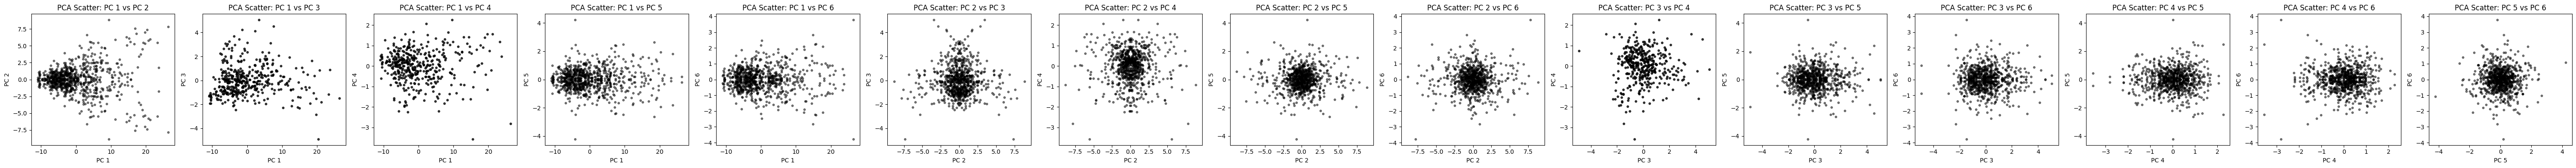

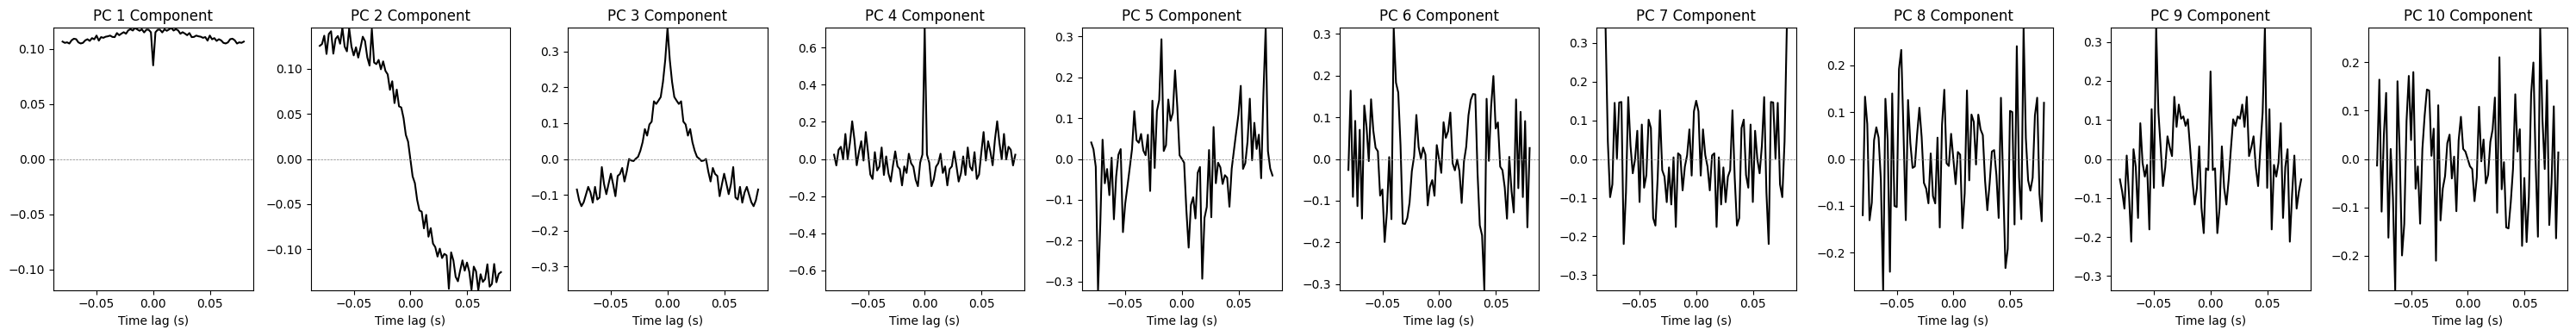

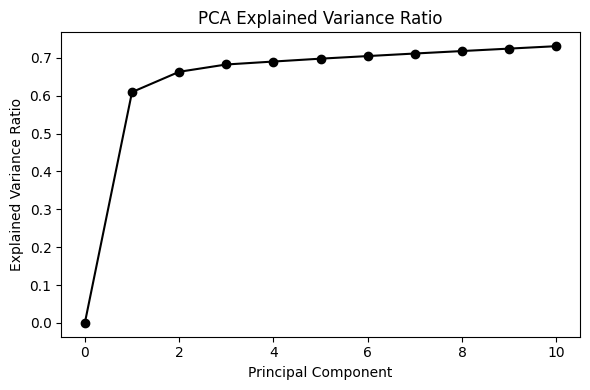

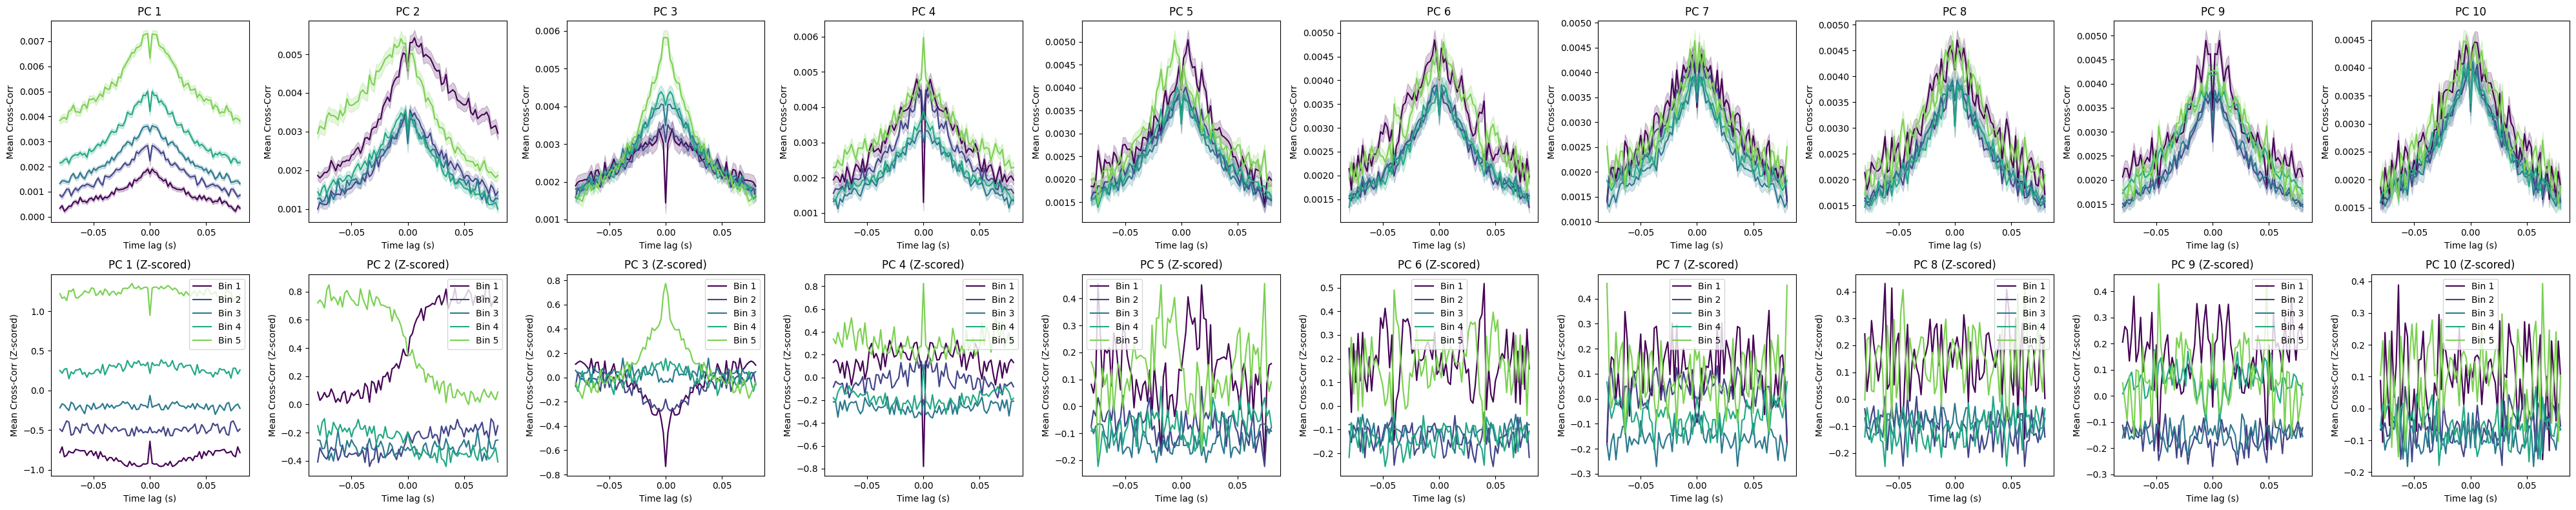

In [152]:
# pca on short timescale cross-corr
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(balanced_short_corr)
short_corr_pca = pca.transform(balanced_short_corr)

fig, axes = plot_pca_pairs(short_corr_pca, max_components=6)
 
# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['short_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'cross_corr_pca_components_short.pdf'), dpi=300)  

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'cross_corr_pca_explained_variance_short.pdf'), dpi=300)


# plot mean of cross correltions binned by score of each pc
num_bins = 5
fig, axes = plt.subplots(2, num_components, figsize=(4*num_components, 8))
for pc_idx in range(num_components):
    pc_scores = short_corr_pca[:, pc_idx]
    bin_edges = np.percentile(pc_scores, np.linspace(0, 100, num_bins + 1))
    binned_means = []
    binned_means_ori = []
    binned_sems = []
    binned_sems_ori = []
    for i in range(num_bins):
        bin_mask = (pc_scores >= bin_edges[i]) & (pc_scores < bin_edges[i + 1])
        bin_data = all_short_corr_for_plot[bin_mask]
        bin_data_ori = balanced_short_corr[bin_mask]
        mean_corr = np.mean(bin_data, axis=0)
        mean_corr_ori = np.mean(bin_data_ori, axis=0)
        sem_corr = np.std(bin_data, axis=0) / np.sqrt(bin_data.shape[0])
        sem_corr_ori = np.std(bin_data_ori, axis=0) / np.sqrt(bin_data_ori.shape[0])
        binned_means.append(mean_corr)
        binned_means_ori.append(mean_corr_ori)
        binned_sems.append(sem_corr)
        binned_sems_ori.append(sem_corr)
    
    # Plotting
    ax = axes[0, pc_idx]
    lags = cross_corr_df.iloc[0]['short_lags']
    for i in range(num_bins):
        ax.plot(lags, binned_means[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means[i] - binned_sems[i], 
                        binned_means[i] + binned_sems[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1}')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr')
    
    ax = axes[1, pc_idx]
    for i in range(num_bins):
        ax.plot(lags, binned_means_ori[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means_ori[i] - binned_sems_ori[i], 
                        binned_means_ori[i] + binned_sems_ori[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1} (Z-scored)')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr (Z-scored)')

    ax.legend()
    plt.tight_layout()
fig.savefig(os.path.join(target_folder, 'cross_corr_pca_binned_means_short.pdf'), dpi=300)

In [153]:
# flip units based on sign of PC2
cross_corr_df_flipped = cross_corr_df.copy()
scores_pc2 = pca.transform(balanced_long_corr[:len(all_long_corr), :])[ :, 1]
flip_indices = scores_pc2 < 0
cross_corr_df_flipped.loc[flip_indices, 'unit_1'], cross_corr_df_flipped.loc[flip_indices, 'unit_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'unit_2'], cross_corr_df_flipped.loc[flip_indices, 'unit_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'].values
cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'].apply(lambda x: np.flip(x))
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'].apply(lambda x: np.flip(x))

In [155]:
PC_1 = long_corr_pca[:len(all_long_corr), 0]
cross_corr_df['PC_1'] = PC_1
PC_2 = long_corr_pca[:len(all_long_corr), 1]
cross_corr_df['PC_2'] = PC_2

In [156]:
peak_win = [0, 7]
inhi_win = [7, 30]
print(f'Long peak window: {times_long[len(times_long)//2]:.3f} to {times_long[len(times_long)//2 + peak_win[1]]:.3f} s')
print(f'Long inhi window: {times_long[len(times_long)//2 + inhi_win[0]]:.3f} to {times_long[len(times_long)//2 + inhi_win[1]]:.3f} s')

Long peak window: 0.000 to 0.350 s
Long inhi window: 0.350 to 1.500 s


In [157]:
# append ccf location
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
# diff
distance_abs = np.abs(cross_corr_df['y_loc_2'].values - cross_corr_df['y_loc_1'].values)
distance_abs[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
distance = (cross_corr_df['y_loc_2'].values - cross_corr_df['y_loc_1'].values)
distance[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
distance_x = (cross_corr_df['x_ccf_2'].values - cross_corr_df['x_ccf_1'].values)
distance_x[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
distance_z = (cross_corr_df['z_ccf_2'].values - cross_corr_df['z_ccf_1'].values)
distance_z[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
distance_y = (cross_corr_df['y_ccf_2'].values - cross_corr_df['y_ccf_1'].values)
distance_y[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance

# rank before adding to dataframe
# distance_abs[~np.isnan(distance_abs)] = rankdata(distance_abs[~np.isnan(distance_abs)])
# rank and center to where distance is 0
# zeros_rank = rankdata(np.concatenate((distance[~np.isnan(distance)], np.array([0]))), method='average')[-1]
# distance[~np.isnan(distance)] = rankdata(distance[~np.isnan(distance)]) - zeros_rank
# zeros_rank = rankdata(np.concatenate((distance_x[~np.isnan(distance_x)], np.array([0]))), method='average')[-1]
# distance_x[~np.isnan(distance_x)] = rankdata(distance_x[~np.isnan(distance_x)]) - zeros_rank
# zeros_rank = rankdata(np.concatenate((distance_z[~np.isnan(distance_z)], np.array([0]))), method='average')[-1]
# distance_z[~np.isnan(distance_z)] = rankdata(distance_z[~np.isnan(distance_z)]) - zeros_rank
dis_sign = np.sign(distance_x)
distance_x_log = np.log(np.abs(1000*distance_x)) * dis_sign

cross_corr_df['distance_abs'] = distance_abs
cross_corr_df['distance'] = distance
cross_corr_df['distance_x'] = distance_x_log
cross_corr_df['distance_z'] = distance_z
cross_corr_df['distance_y'] = distance_y


# mean
mean_z_ccf = (cross_corr_df['z_ccf_1'].values + cross_corr_df['z_ccf_2'].values) / 2
mean_z_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
mean_y_ccf = (cross_corr_df['y_ccf_1'].values + cross_corr_df['y_ccf_2'].values) / 2
mean_y_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
mean_x_ccf = (cross_corr_df['x_ccf_1'].values + cross_corr_df['x_ccf_2'].values) / 2
mean_x_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance

cross_corr_df['mean_z_ccf'] = mean_z_ccf
cross_corr_df['mean_y_ccf'] = mean_y_ccf
cross_corr_df['mean_x_ccf'] = mean_x_ccf

# # rank ccf location
mean_x_ccf[~np.isnan(mean_x_ccf)] = rankdata(mean_x_ccf[~np.isnan(mean_x_ccf)])
mean_y_ccf[~np.isnan(mean_y_ccf)] = rankdata(mean_y_ccf[~np.isnan(mean_y_ccf)])
mean_z_ccf[~np.isnan(mean_z_ccf)] = rankdata(mean_z_ccf[~np.isnan(mean_z_ccf)])


cross_corr_df['mean_z_ccf_rank'] = mean_z_ccf
cross_corr_df['mean_y_ccf_rank'] = mean_y_ccf
cross_corr_df['mean_x_ccf_rank'] = mean_x_ccf

# Long: cross-corr metrics
peak_cross = [cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2] for i in range(len(cross_corr_df))]
peak_cross = np.array(peak_cross)
peak_win_cross = [np.mean(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - peak_win[1]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + peak_win[1]]) for i in range(len(cross_corr_df))]
peak_win_cross = np.array(peak_win_cross)
inhi_win_cross_outer = [np.sum(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[1]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[1]]) for i in range(len(cross_corr_df))]
inhi_win_cross_outer = np.array(inhi_win_cross_outer)
inhi_win_cross_inner = [np.sum(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[0]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[0]]) for i in range(len(cross_corr_df))]
inhi_win_cross_inner = np.array(inhi_win_cross_inner)
inhi_win_cross = inhi_win_cross_outer - inhi_win_cross_inner
inhi_win_asy_cross_right = [np.mean(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[0]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[1]]) 
                            for i in range(len(cross_corr_df))]
inhi_win_asy_cross_left = [np.mean(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[1]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[0]]) 
                           for i in range(len(cross_corr_df))]
inhi_win_asy_cross = (np.array(inhi_win_asy_cross_right) - np.array(inhi_win_asy_cross_left))/(peak_cross+0.2)


# rank peak cross
# peak_cross[~np.isnan(peak_cross)] = rankdata(peak_cross[~np.isnan(peak_cross)])
# inhi_win_asy_cross[~np.isnan(inhi_win_asy_cross)] = rankdata(inhi_win_asy_cross[~np.isnan(inhi_win_asy_cross)])

cross_corr_df['peak_cross'] = peak_cross
cross_corr_df['inhi_win_cross'] = inhi_win_cross
cross_corr_df['peak_win_cross'] = peak_win_cross
cross_corr_df['inhi_win_asy_cross'] = inhi_win_asy_cross

# short
peak_cross_short = [cross_corr_df.iloc[i]['cross_corr_short_nogo'][len(cross_corr_df.iloc[i]['cross_corr_short_nogo']) // 2] for i in range(len(cross_corr_df))]
peak_cross_short = np.array(peak_cross_short)
cross_corr_df['peak_cross_short'] = peak_cross_short
PC_1 = short_corr_pca[:len(all_short_corr), 0]
PC_2 = short_corr_pca[:len(all_short_corr), 1]
cross_corr_df['PC_1_short'] = PC_1
cross_corr_df['PC_2_short'] = PC_2


In [158]:
focus_features = ['PC_1', 'PC_2', 'PC_1_short', 'PC_2_short', 'peak_cross_short',
                'inhi_win_cross', 'peak_win_cross', 'inhi_win_asy_cross']

In [125]:
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = np.abs(mesh_vertices_mm[:, ml])

ccfs = cross_corr_df[['mean_x_ccf', 'mean_y_ccf', 'mean_z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left

# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [122]:
# compute spatial dependence for each feature
spatial_dependence_results = {}
for feature in focus_features:
    values = cross_corr_df[feature].values
    results = spatial_dependence_summary(ccfs, values, k_neighbors=30, n_splits=5, permutations=5000, seed=42)
    spatial_dependence_results[feature] = results

In [123]:
families = {'long': ['PC_1', 'PC_2', 'inhi_win_cross', 'peak_win_cross', 'inhi_win_asy_cross'],
            'short': ['PC_1_short', 'PC_2_short', 'peak_cross_short']}
from statsmodels.stats.multitest import multipletests
# family-wise multiple comparison correction
for family_name, feature_list in families.items():
    p_values = [spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation'] for feature in feature_list]
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    for i, feature in enumerate(feature_list):
        spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
        spatial_dependence_results[feature]['cv_predictability_knn']['significant_fdr'] = reject[i]
    p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_F_test_vs_intercept_only'] for feat in focus_features]
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    for i, feature in enumerate(focus_features):
        spatial_dependence_results[feature]['linear_trend']['p_value_F_test_vs_intercept_only_fdr'] = pvals_corrected[i]
        spatial_dependence_results[feature]['linear_trend']['significant_fdr'] = reject[i]

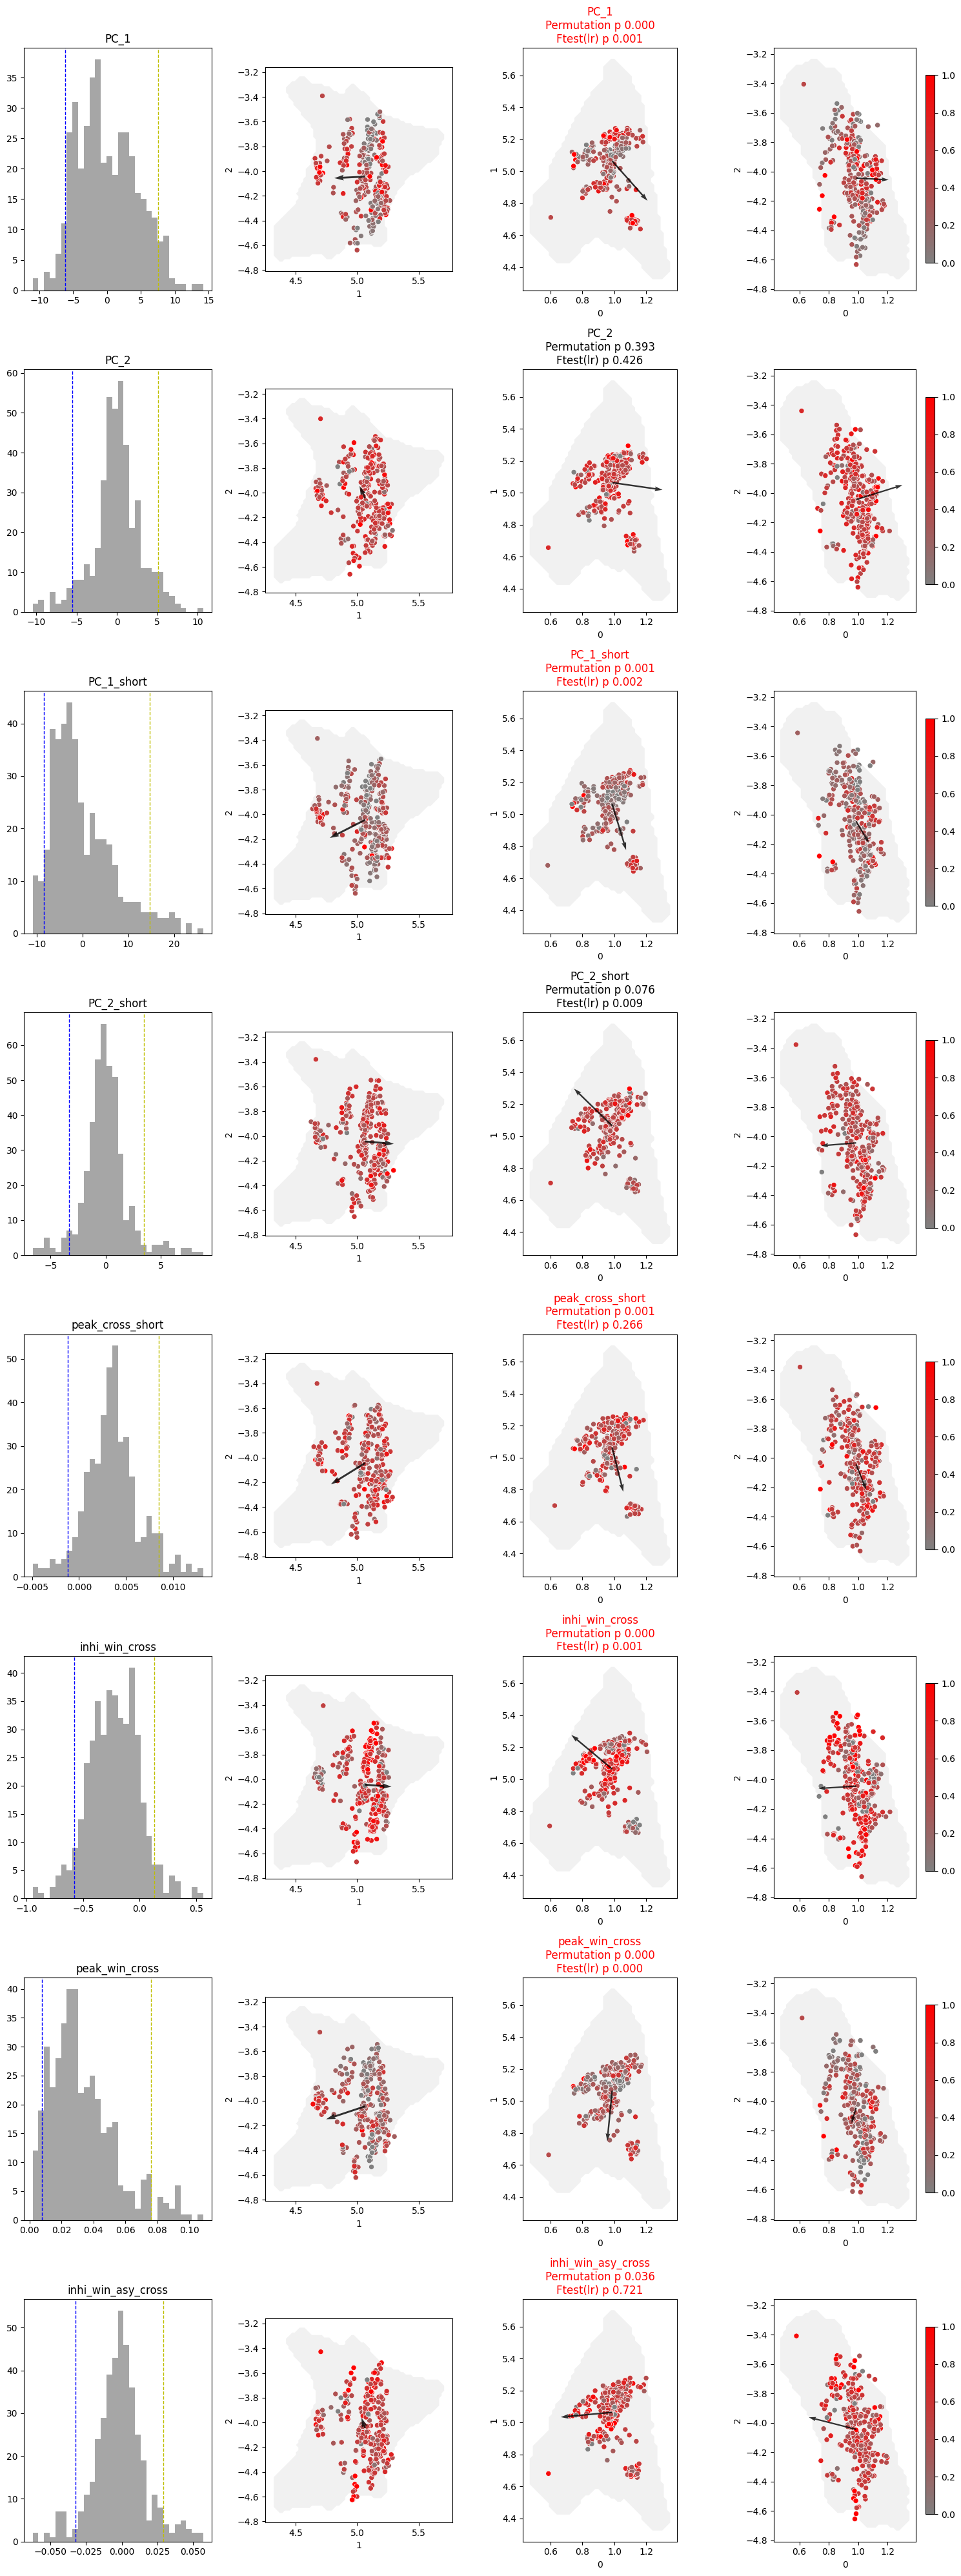

In [129]:
filter = ~np.isnan(ccfs).any(axis=1)
cmap = LinearSegmentedColormap.from_list('feature_cmap', [(0.0, 'gray'), (1.0, 'red')])
fig, axes = plt.subplots(len(focus_features), 4, figsize=(15, 5*len(focus_features)))

for ind, feature in enumerate(focus_features):
    ax = axes[ind, 0]
    color_code = cross_corr_df[feature].values
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    top_90 = np.quantile(color_code, 0.95)
    bottom_10 = np.quantile(color_code, 0.05)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    sort_ind = np.random.choice(range(len(color_code_nl)), size=len(sort_ind), replace=False)
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        jitter_on_x = np.random.normal(0, 0.02, size=ccfs.shape[0])
        jitter_on_y = np.random.normal(0, 0.02, size=ccfs.shape[0])
        sc = ax.scatter(ccfs[sort_ind, planes[plane][0]] + jitter_on_x, ccfs[sort_ind, planes[plane][1]] + jitter_on_y, c=color_code_nl[sort_ind], cmap=cmap, s=35, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['significant_fdr']:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"Permutation p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation_fdr']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results[feature]['linear_trend']['p_value_F_test_vs_intercept_only_fdr']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'cross_corr_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'cross_corr_feature_in_space_{criteria_name}.png'), dpi=300, bbox_inches='tight')



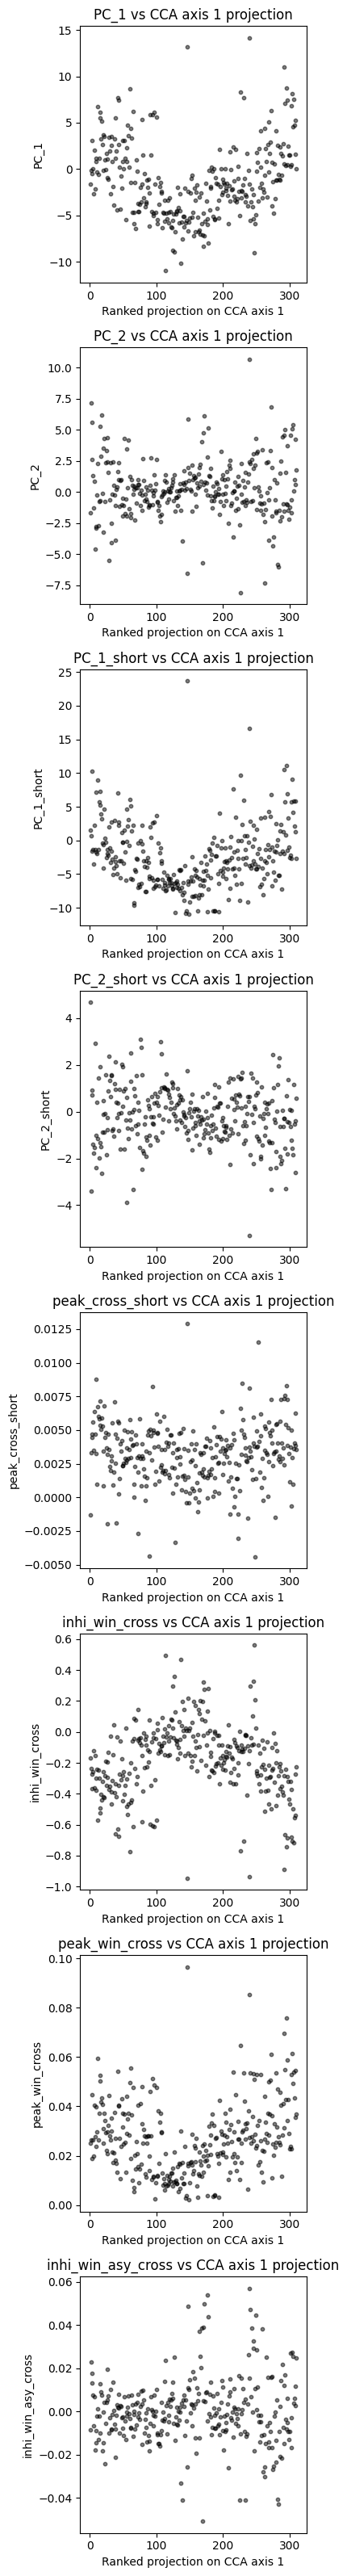

In [159]:
# plot features along the cca axis
cca_1 = np.array([-0.2636, -0.9645, -0.0140])
cca_2 = np.array([-0.7005, 0.2014, -0.6847]) 
# project ccfs to cca axis and plot against features
fig, axes = plt.subplots(len(focus_features), 1, figsize=(4, 4*len(focus_features)))
for ind, feature in enumerate(focus_features):
    ax = axes[ind]
    values = cross_corr_df[feature].values
    projections = ccfs @ cca_1
    projections[~np.isnan(projections)] = rankdata(projections[~np.isnan(projections)])
    ax.scatter(projections, values, color='k', alpha=0.5, s=10)
    # fit linear regression
    # from sklearn.linear_model import LinearRegression
    # lr = LinearRegression()
    # valid_ind = ~np.isnan(values)
    # lr.fit(projections.reshape(-1, 1), values)
    # x_fit = np.linspace(np.min(projections), np.max(projections), 100)
    # y_fit = lr.predict(x_fit.reshape(-1, 1))
    # ax.plot(x_fit, y_fit, color='red', linewidth=2)
    ax.set_xlabel('Ranked projection on CCA axis 1')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs CCA axis 1 projection')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'cross_corr_feature_vs_beh_cca1_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

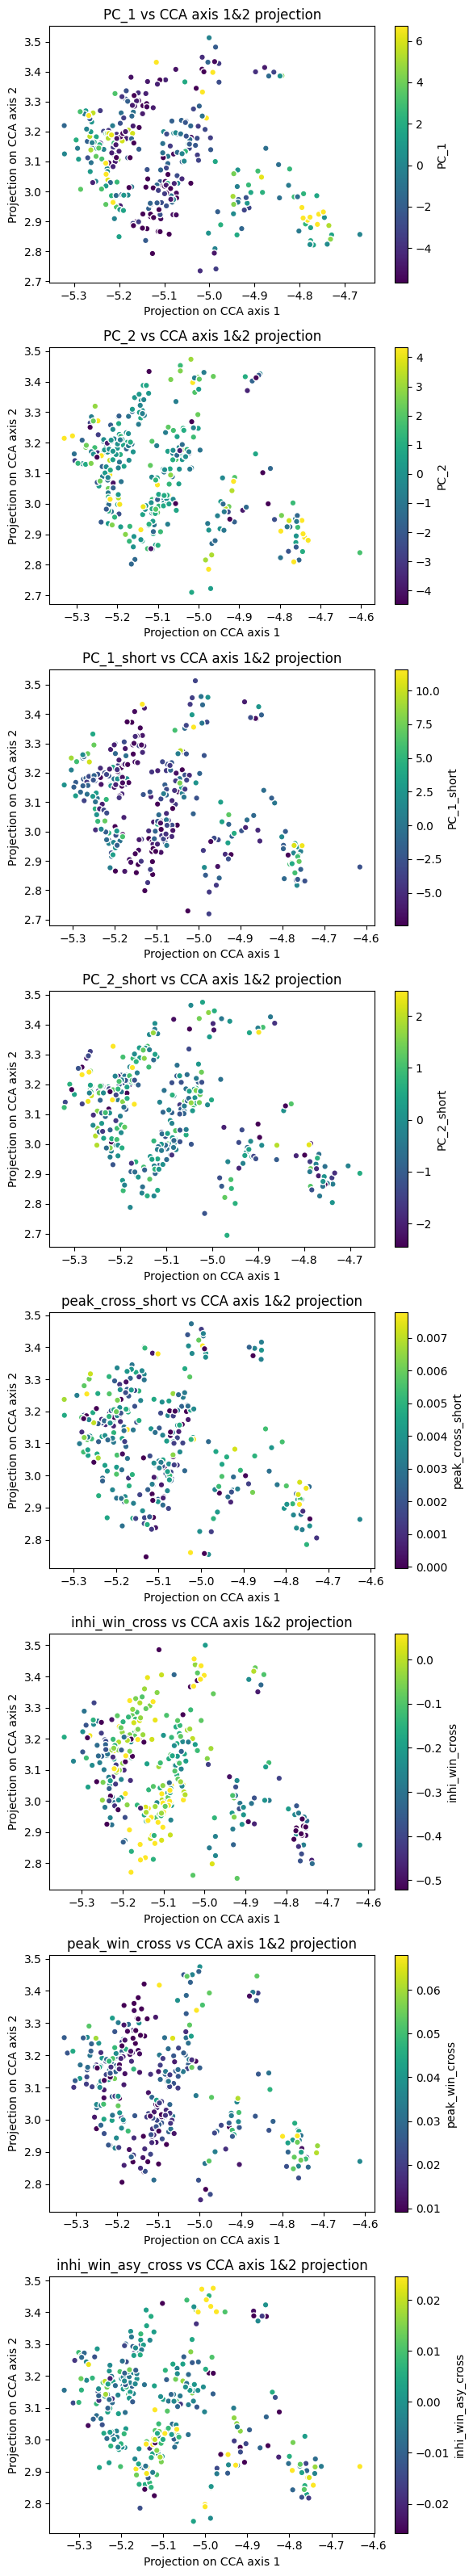

In [165]:
# plot features along the cca axis
cca_1 = np.array([-0.2636, -0.9645, -0.0140])
cca_2 = np.array([-0.7005, 0.2014, -0.6847]) 
# project ccfs to cca axis and plot against features
fig, axes = plt.subplots(len(focus_features), 1, figsize=(6, 4*len(focus_features)))
for ind, feature in enumerate(focus_features):
    ax = axes[ind]
    values = cross_corr_df[feature].values.copy()
    up_lim = np.quantile(values, 0.92)
    low_lim = np.quantile(values, 0.08)
    values[values > up_lim] = up_lim
    values[values < low_lim] = low_lim
    projections = np.stack(arrays=[ccfs @ cca_1, ccfs @ cca_2], axis=1)
    # projections_1[~np.isnan(projections)] = rankdata(projections[~np.isnan(projections)])
    jitter_on_x = np.random.normal(0, 0.02, size=ccfs.shape[0])
    jitter_on_y = np.random.normal(0, 0.02, size=ccfs.shape[0])
    ax.scatter(projections[:, 0] + jitter_on_x, projections[:, 1]+jitter_on_y, c=values, cmap='viridis', alpha=1, s=30, edgecolor='white', linewidth=1)
    # fit linear regression
    # from sklearn.linear_model import LinearRegression
    # lr = LinearRegression()
    # valid_ind = ~np.isnan(values)
    # lr.fit(projections.reshape(-1, 1), values)
    # x_fit = np.linspace(np.min(projections), np.max(projections), 100)
    # y_fit = lr.predict(x_fit.reshape(-1, 1))
    # ax.plot(x_fit, y_fit, color='red', linewidth=2)
    ax.set_xlabel('Projection on CCA axis 1')
    ax.set_ylabel('Projection on CCA axis 2')
    ax.set_title(f'{feature} vs CCA axis 1&2 projection')
    # all colorbar
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(feature)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'cross_corr_feature_vs_beh_cca1&2_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

In [ ]:
# load behavior features and compare similarity